In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [2]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

# Read Data

Let's first read in the meta data of all models in the dataset.

In [3]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|███████████████████████████████████████████████████████████████████████████| 103/103 [03:13<00:00,  1.88s/it]


,revision_id,organization_id,datetime,description,name,type,namespace
model_id,,,,,,,
1ba74449e9354d0c9d4798b4a6e915d0,5ed1535c95a342f4a414dd8c9b1b7df8,6c96d0b6e5e14eeaa9848f953a94e5f8,2019-03-19 11:36:50,NaN,Pivo,NaN,http://b3mn.org/stencilset/bpmn2.0#
1ba744cbcafb46c2a52482e36498a9bf,301bfb5af53c431a830a6e435de6a590,8af3fc1bb4b74e7c8c4089e4921d9056,2020-03-23 17:26:03,NaN,Receipt of Application,NaN,http://b3mn.org/stencilset/bpmn2.0#
1ba7587b3191422fb03a0e9ba92cebff,ac3baa3e59ca476396b4affa8e900c6f,36fbc1ee23334e1ab987b07d2108eef2,2017-04-19 06:19:36,NaN,710 BPMN Conference room,NaN,http://b3mn.org/stencilset/bpmn2.0#
1ba758f87e744ff0bcb3119887cac8cc,da11513a93224fbbb2c34ef9c5cfcaa9,574093f96e5e4ff09a8b1f24eeb70284,2021-02-21 13:14:32,NaN,ECU application p,NaN,http://b3mn.org/stencilset/bpmn2.0#
1ba77121c3be44d6bd0b354727f9707b,70d06e82d8c344edab8b041f8b03161a,ff66cd6b779c44bba88ade8952d7e626,2020-06-30 07:12:48,NaN,2.9.1 Elektronischer Auftrag erfassen,NaN,http://b3mn.org/stencilset/bpmn2.0#


# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [4]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)
df_notations

,Notation,Frequency
0,http://b3mn.org/stencilset/bpmn2.0#,618807
1,http://www.signavio.com/stencilsets/processmap#,194078
2,http://signavio.com/stencilsets/dmn-1.0#,98286
3,http://b3mn.org/stencilset/epc#,32369
4,http://b3mn.org/stencilset/bpmn1.1#,15643
5,http://b3mn.org/stencilset/UML2.2Class#,14953
6,http://b3mn.org/stencilset/petrinet#,11207
7,http://cisco.com/stencilset/archimate-2.1#,10956
8,http://b3mn.org/stencilset/UMLUseCase#,10228
9,http://www.signavio.com/stencilsets/organigram#,4568


We map the namespaces to the common names for the modeling notations.

In [5]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
df_notations = df_notations.replace({'Notation' : d_namespaces})
df_notations

,Notation,Frequency
0,BPMN 2.0,618807
1,Value Chain,194078
2,DMN 1.0,98286
3,EPC,32369
4,BPMN 1.1,15643
5,UML 2.2 Class,14953
6,Petri Net,11207
7,ArchiMate 2.1,10956
8,UML Use Case,10228
9,Organigram,4568


And we aggregate modeling notations which are used for less than 100 models in "Other".

In [6]:
other_dict={
 'Process Documentation Template':'Other',
 'jBPM 4':'Other',
 'XForms':'Other',
 'Chen Notation':'Other'
}
last_x = len(other_dict)
df_notations_upper = df_notations.iloc[:-last_x,:]
df_notations_other = df_notations.iloc[len(df_notations)-last_x:,:].replace({'Notation': other_dict}).groupby('Notation').sum().reset_index()
df_notations=pd.concat([df_notations_upper,df_notations_other],ignore_index=True)
df_notations.tail()

,Notation,Frequency
13,CMMN 1.0,999
14,CPN,385
15,Journey Map,287
16,YAWL 2.2,238
17,Other,185


Now we visualize the number of models in different modeling notations.

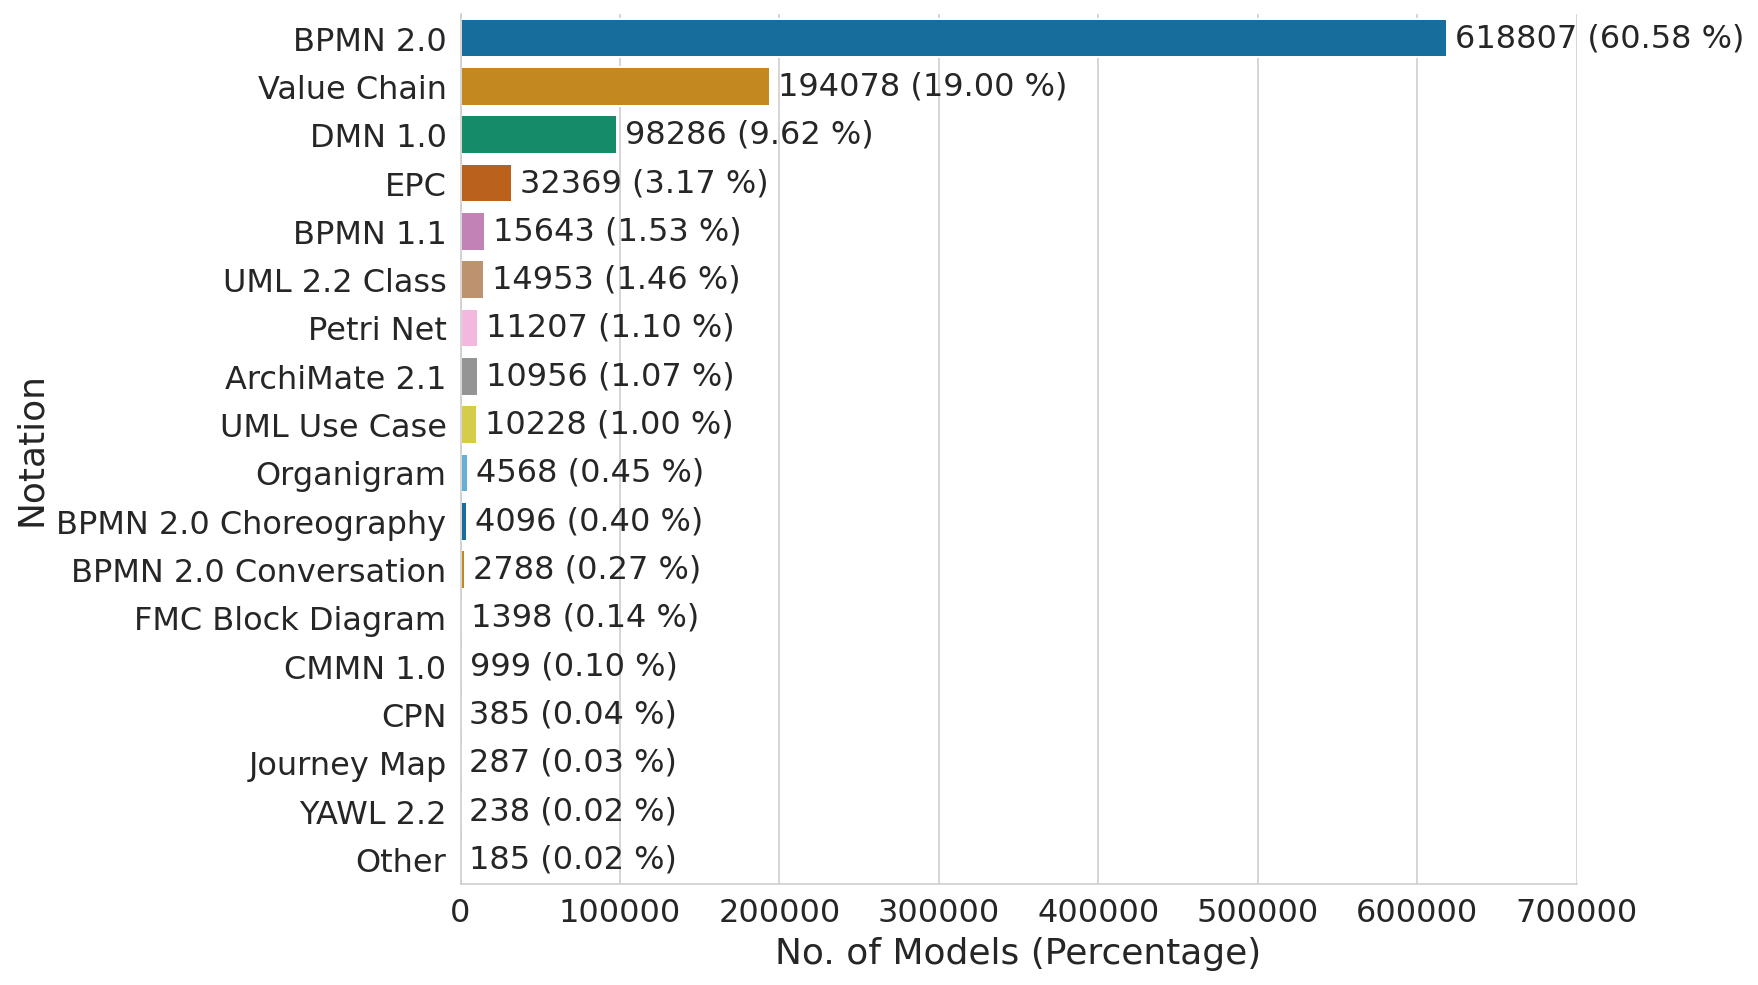

In [7]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
ax=sns.barplot(x="Frequency", y="Notation", data=df_notations, estimator = np.max,ci = 0, palette = sns.color_palette("colorblind"))
sns.despine()
ax.bar_label(ax.containers[0], label_type='edge', padding=4, labels=[f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations['Frequency']])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

By using the datetime column, we can also consider the creation of models in different notations over time.

In [8]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [9]:
df_meta.sort_values('datetime').head(1)

,revision_id,organization_id,datetime,description,name,type,namespace
model_id,,,,,,,
b29f8731e455480fb0b0a5c0d810280c,5b89d8c57ee74988916f552c0e515ef2,c78f482cc9d54a278154a3d1671450db,2011-07-06 13:48:02,Overview of the relevant steps in the course o...,Value chain: Procurement,Prozesslandkarte,http://www.signavio.com/stencilsets/processmap#


In [10]:
df_meta.sort_values('datetime').tail(1)

,revision_id,organization_id,datetime,description,name,type,namespace
model_id,,,,,,,
0507df8deb7847e0a97d7515663e168d,9c6d4bceab634d7ca854edb71d3b5f0b,30da146aae4842cfab909b9723944f7a,2021-09-22 03:19:14,NaN,OSPCC Related Queries-As-Is Model (Updated),NaN,http://b3mn.org/stencilset/bpmn2.0#


Let's check the creation of models over time for the five most used notations.

In [11]:
selected_notations = [d_namespaces_reverse[i] for i in df_notations.Notation.values[:5]]
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations) ]
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

/tmp/ipykernel_1580738/1585375657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_selected['Count']= 1


We count the number of models created per year.

In [12]:
df_meta_selected=df_meta_selected.groupby('namespace').resample('Y').sum().reset_index()
df_meta_selected['Year']= df_meta_selected['datetime'].apply(lambda x:x.year)
df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected

,namespace,datetime,Count,Year
0,BPMN 1.1,2015-12-31,205,2015
1,BPMN 1.1,2016-12-31,596,2016
2,BPMN 1.1,2017-12-31,1401,2017
3,BPMN 1.1,2018-12-31,2418,2018
4,BPMN 1.1,2019-12-31,2201,2019
5,BPMN 1.1,2020-12-31,3423,2020
6,BPMN 1.1,2021-12-31,5399,2021
7,BPMN 2.0,2012-12-31,6,2012
8,BPMN 2.0,2013-12-31,0,2013
9,BPMN 2.0,2014-12-31,0,2014


Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [13]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

27

In [14]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2021]
df_meta_selected.head()

,namespace,datetime,Count,Year
0,BPMN 1.1,2015-12-31,205,2015
1,BPMN 1.1,2016-12-31,596,2016
2,BPMN 1.1,2017-12-31,1401,2017
3,BPMN 1.1,2018-12-31,2418,2018
4,BPMN 1.1,2019-12-31,2201,2019


In [15]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 1440x720 with 0 Axes>

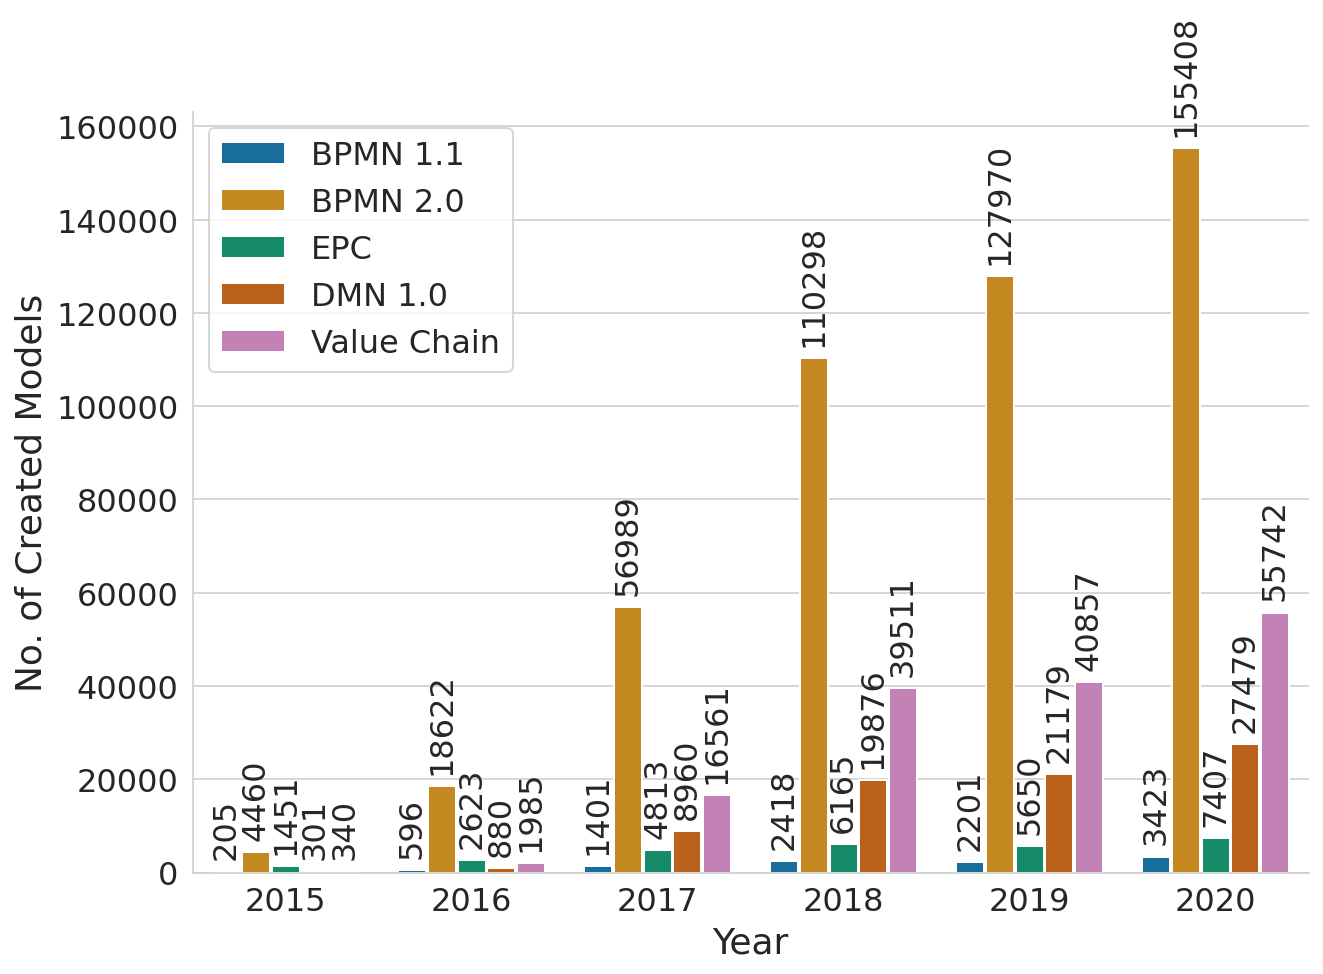

In [16]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax,palette=sns.color_palette("colorblind"))
plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [17]:
selected_notations_short = [d_namespaces[n] for n in selected_notations]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked,index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

,BPMN 2.0,Value Chain,DMN 1.0,EPC,BPMN 1.1
2020,155408,55742,27479,7407,3423
2019,127970,40857,21179,5650,2201
2018,110298,39511,19876,6165,2418
2017,56989,16561,8960,4813,1401
2016,18622,1985,880,2623,596
2015,4460,340,301,1451,205


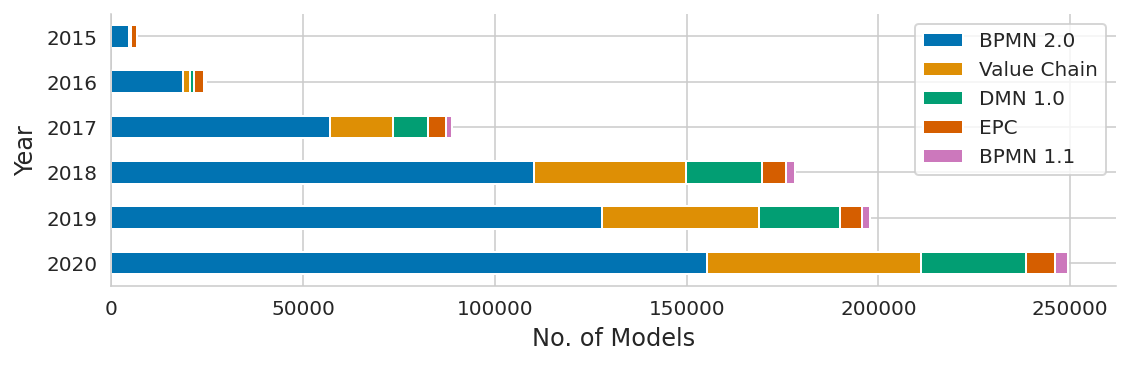

In [18]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [19]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]

Number of BPMN 2.0 models:

In [20]:
len(df_meta_bpmn)

618807

We use the BPMNModelParser to parse the BPMN 2.0 models. In case, we have already parsed them, we load the parsed data from the pkl file.

In [21]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
# df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  
model_id                         element_id                                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                        
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n  
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                        
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n  
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262

Number of BPMN 2.0 models from the parser:

In [22]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

605506

The difference in the number of BPMN 2.0 models shows that there are some empty BPMN 2.0 models in the dataset which do not contain any elements. 

The total number of elements of all BPMN 2.0 models is:

In [23]:
len(df_bpmn)

28293762

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [24]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 7.4 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [25]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

,label,detected_natural_language
model_id,,
52be6170b716443e891d3639d79affa0,Installerad braskamin Skicka bygganmälan\n In...,sv
52be95790bc04964877014eb6b9a3edf,Work equipment\n not in stock Work\n equipment...,en
52bea2dfaf764944986a91e71dda0afc,Licht in der Kaffeküche\n\n Lampe Prozess ist...,de
52beafce8e084ebca4a774287f4dfeaa,NOT AVAILABLE AVAILABLE PO COMFIRMED INVOICE P...,en
52bebfc42f40486d92449d884620147f,Supplier ACME AG IT-Department Personnel Syst...,en


Let's plot the use of different languages across the dataset.

In [26]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [27]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

,Language,No. of Models
0,English,347730
1,German,158956
2,Italian,19307
3,Spanish,17282
4,French,9459
5,Croatian,8345
6,Portuguese,6698
7,Estonian,4874
8,Dutch,4845
9,Slovenian,4133


We only plot the 10 most common languages.

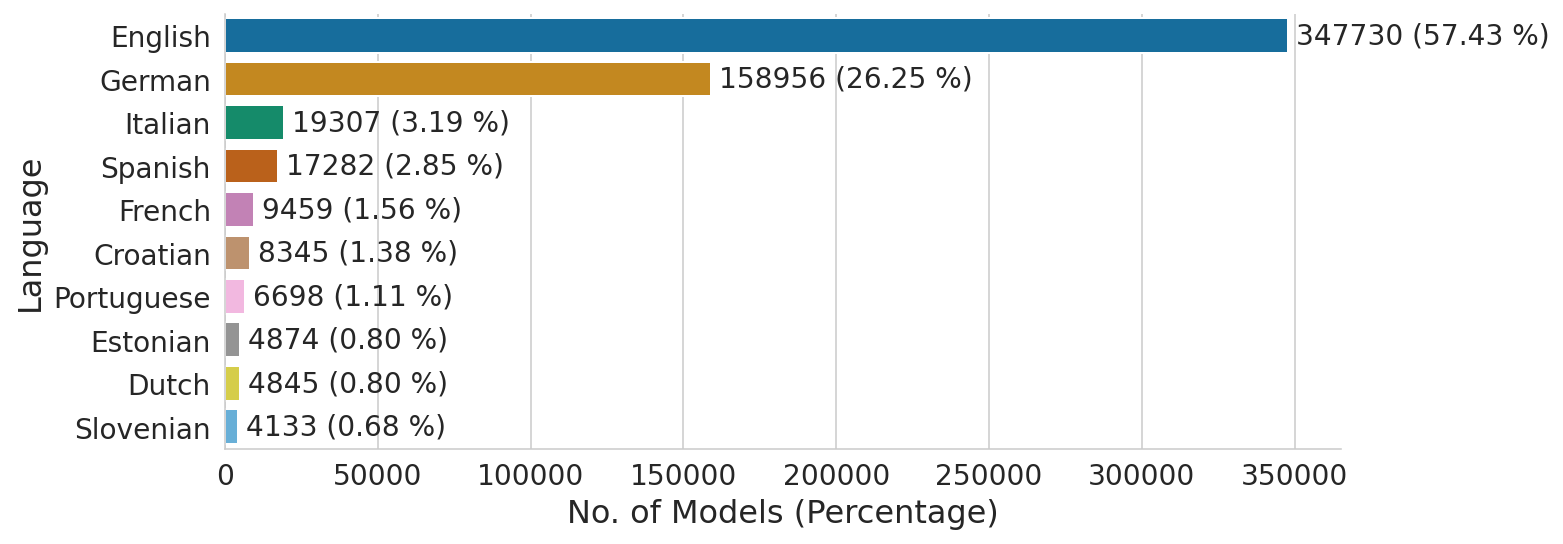

In [28]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:10]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", data=df_lang,palette=sns.color_palette("colorblind"))
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']])
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Now we want to examine the usage of element types in the BPMN models.

In [29]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [30]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0, downcast="infer") # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

,SequenceFlow,EndNoneEvent,CollapsedSubprocess,Task,StartNoneEvent,total_count,Association_Undirected,Association_Unidirectional,MessageFlow,CollapsedPool,Pool,Lane,DataObject,Exclusive_Databased_Gateway,IntermediateMessageEventCatching,IntermediateTimerEvent,EventbasedGateway,ITSystem,ParallelGateway,StartMessageEvent,IntermediateMessageEventThrowing,processparticipant,EndMessageEvent,TextAnnotation,Message,EndEscalationEvent,DataStore,IntermediateEscalationEvent,IntermediateMultipleEventCatching,Subprocess,EndErrorEvent,StartTimerEvent,IntermediateErrorEvent,IntermediateEvent,InclusiveGateway,EndTerminateEvent,StartCompensationEvent,EndCompensationEvent,StartMultipleEvent,Association_Bidirectional,IntermediateSignalEventThrowing,EndCancelEvent,IntermediateLinkEventCatching,Group,EventSubprocess,StartConditionalEvent,IntermediateConditionalEvent,IntermediateParallelMultipleEventCatching,IntermediateSignalEventCatching,EndSignalEvent,IntermediateLinkEventThrowing,IntermediateCompensationEventCatching,ComplexGateway,StartParallelMultipleEvent,StartSignalEvent,VerticalPool,VerticalLane,IntermediateCancelEvent,CollapsedEventSubprocess,StartErrorEvent,StartEscalationEvent,IntermediateEscalationEventThrowing,IntermediateCompensationEventThrowing,CollapsedVerticalPool,EndMultipleEvent,IntermediateMultipleEventThrowing,ConversationLink,Communication,Participant,ChoreographyTask,ChoreographyParticipant,gdottedline,gdashedline,gtext,gellipse,gdiamond,grect
0,4,1,1,2,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14,2,0,5,1,40,1,2,3,1,1,1,2,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,1,0,2,1,21,0,0,0,0,1,2,0,0,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12,2,0,6,0,33,0,0,4,0,2,3,0,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,1,1,3,1,31,2,3,2,1,1,3,2,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


These are the statistics of the different element types per model:

In [31]:
cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count    605506.000000
mean         11.291829
std           3.936904
min           1.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          62.000000
dtype: float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [32]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0, downcast="infer")
)
df_cnts.head()

category,Association_Bidirectional,Association_Undirected,Association_Unidirectional,ChoreographyParticipant,ChoreographyTask,CollapsedEventSubprocess,CollapsedPool,CollapsedSubprocess,CollapsedVerticalPool,Communication,ComplexGateway,ConversationLink,DataObject,DataStore,EndCancelEvent,EndCompensationEvent,EndErrorEvent,EndEscalationEvent,EndMessageEvent,EndMultipleEvent,EndNoneEvent,EndSignalEvent,EndTerminateEvent,EventSubprocess,EventbasedGateway,Exclusive_Databased_Gateway,Group,ITSystem,InclusiveGateway,IntermediateCancelEvent,IntermediateCompensationEventCatching,IntermediateCompensationEventThrowing,IntermediateConditionalEvent,IntermediateErrorEvent,IntermediateEscalationEvent,IntermediateEscalationEventThrowing,IntermediateEvent,IntermediateLinkEventCatching,IntermediateLinkEventThrowing,IntermediateMessageEventCatching,IntermediateMessageEventThrowing,IntermediateMultipleEventCatching,IntermediateMultipleEventThrowing,IntermediateParallelMultipleEventCatching,IntermediateSignalEventCatching,IntermediateSignalEventThrowing,IntermediateTimerEvent,Lane,Message,MessageFlow,ParallelGateway,Participant,Pool,SequenceFlow,StartCompensationEvent,StartConditionalEvent,StartErrorEvent,StartEscalationEvent,StartMessageEvent,StartMultipleEvent,StartNoneEvent,StartParallelMultipleEvent,StartSignalEvent,StartTimerEvent,Subprocess,Task,TextAnnotation,VerticalLane,VerticalPool,gdashedline,gdiamond,gdottedline,gellipse,grect,gtext,processparticipant
model_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000150e890c45928d26584d491ada68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,5,0,0,2,0,1,28,0,0,0,0,0,0,1,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0
00001f477e9a4fb1b9dcb27e029a426d,0,2,3,0,0,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,2,0,1,8,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
00003a67300748639e4bc21398bb5ede,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0
00005cea16fd426881c7f1619e30b804,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,2,0,1,14,0,0,0,0,0,0,2,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0
0000c3ea6c58407dbfaeac9ef5e467e7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,1,0,3,0,0,1,16,0,0,0,0,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0


In [33]:
df_cnts.drop(["gdashedline","gdiamond","gdottedline","gellipse","grect","gtext"],axis=1,inplace=True)

In [34]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
len(df_freq[df_freq["frequency"]/len(df_cnts) < 0.1])

49

In [35]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())
df_freq.head()

,category,frequency
0,Sequence flow,598712
1,Task,594055
2,End none event,558940
3,Lane,502013
4,Pool,501858


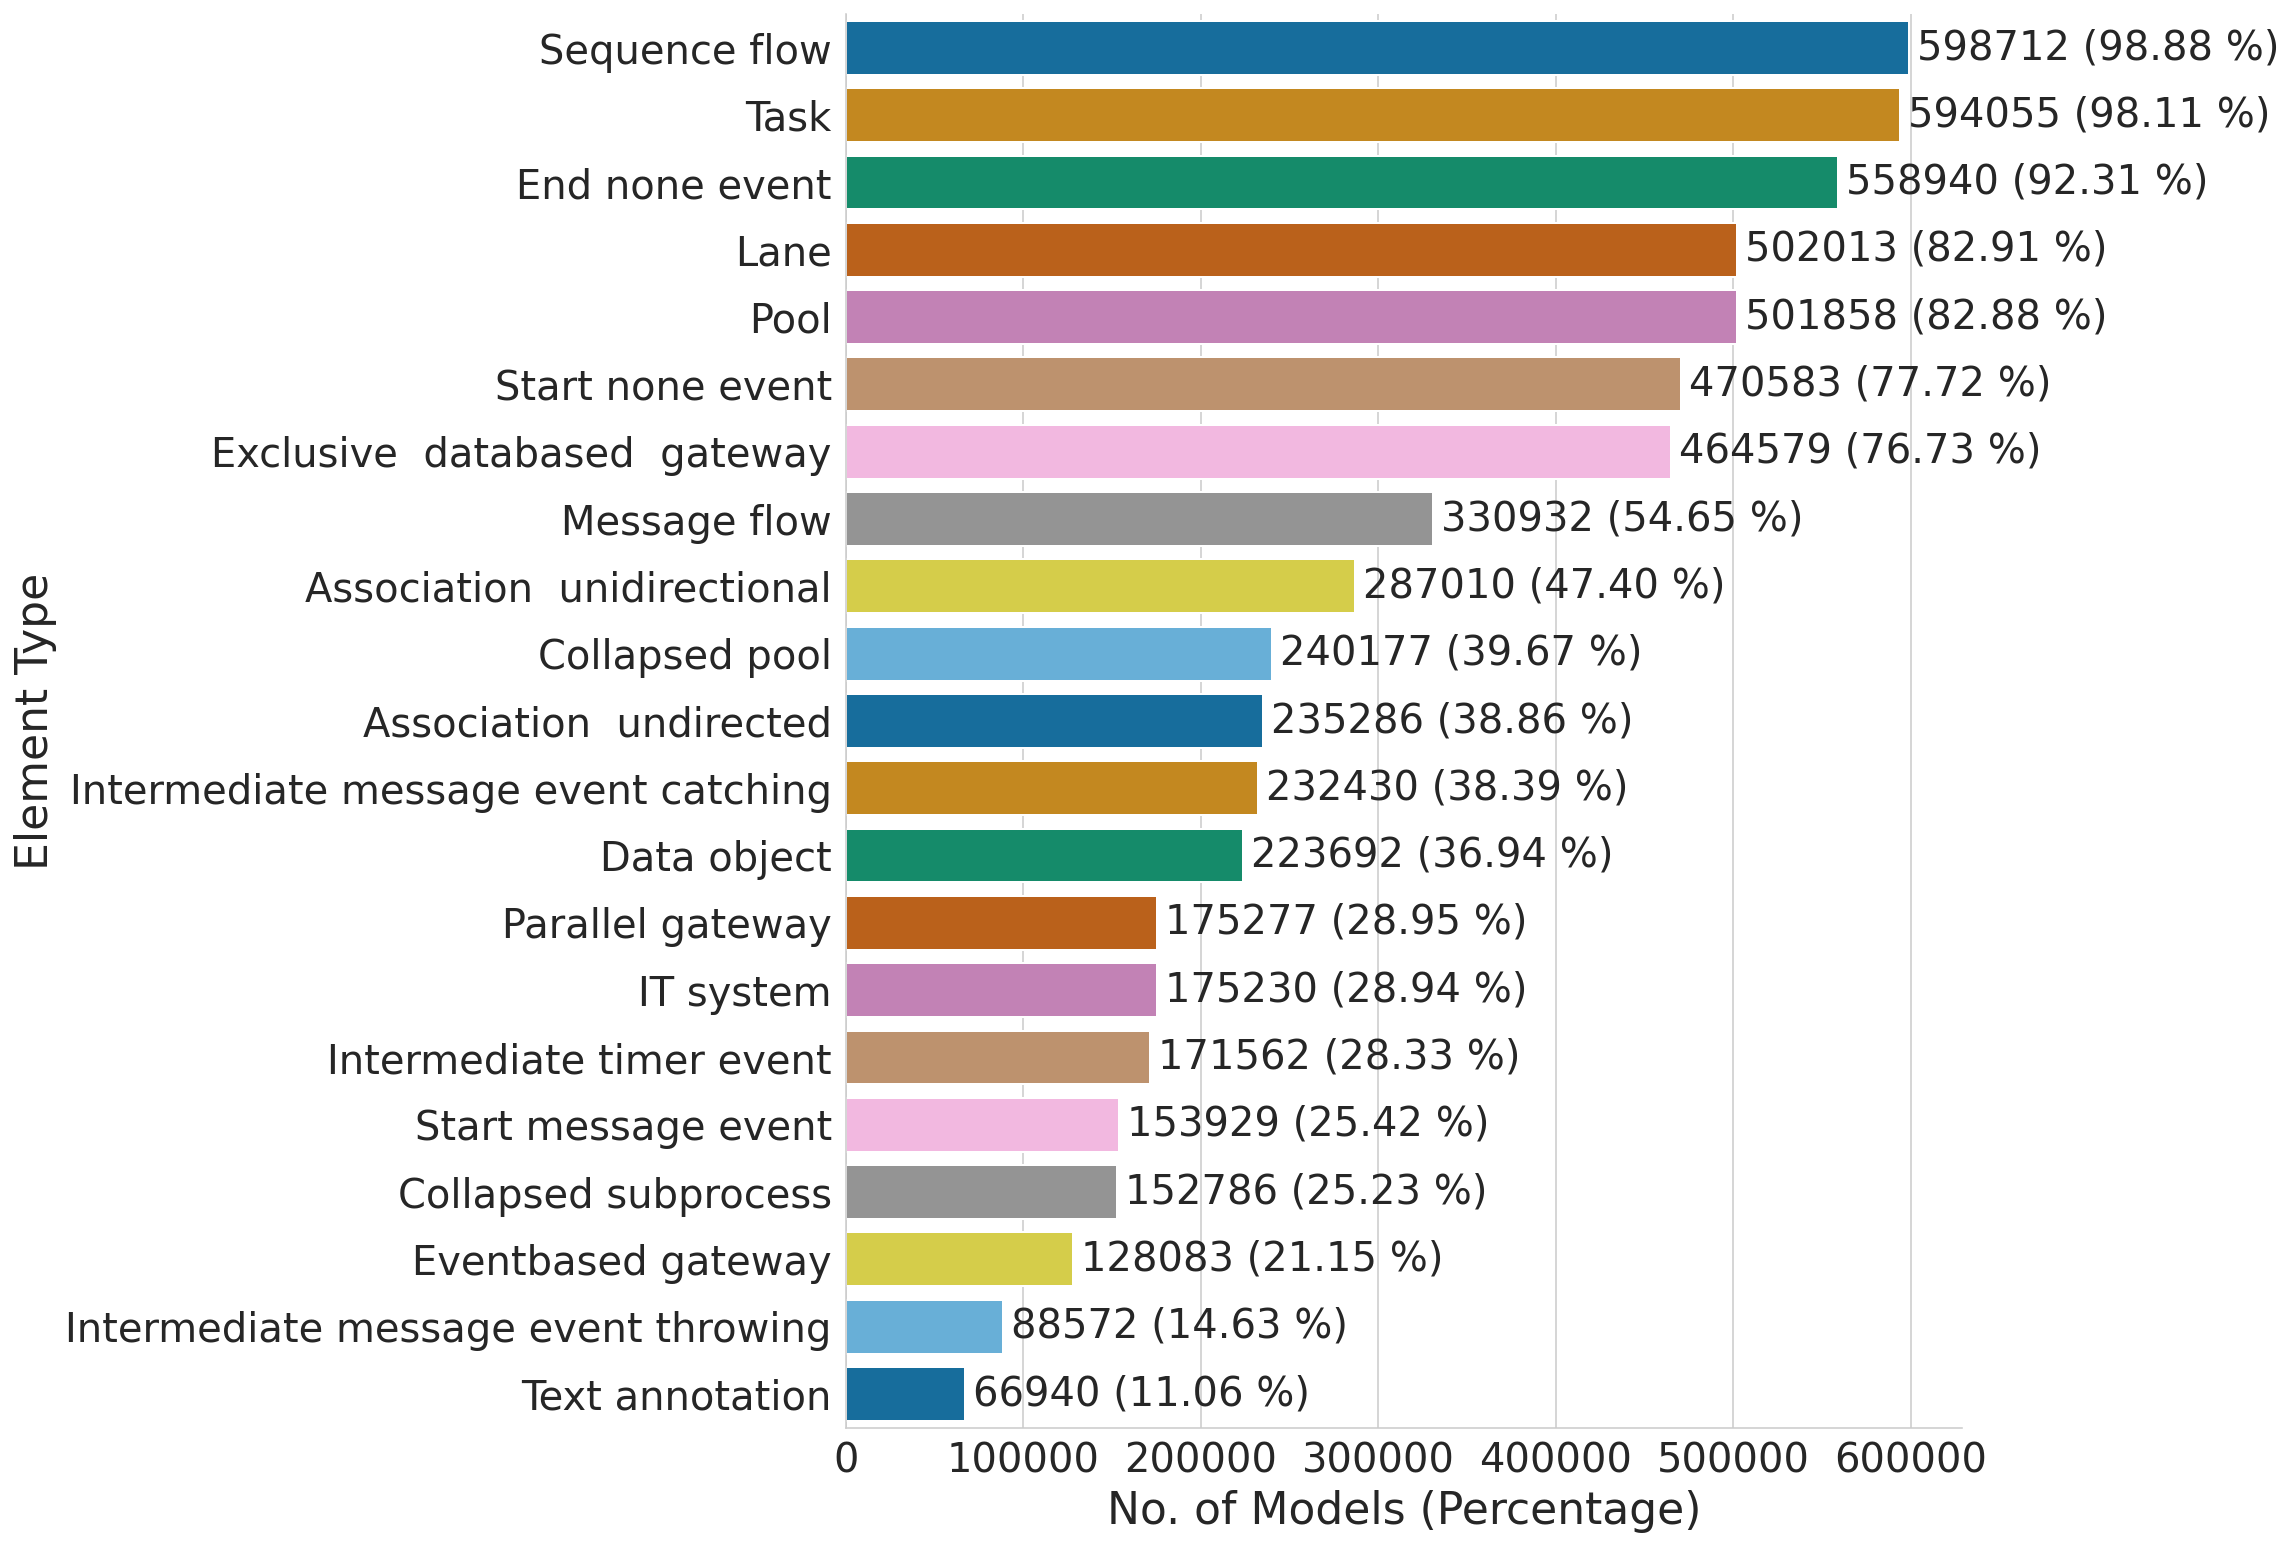

In [36]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
ax = sns.barplot(x="frequency", y="category", data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind"));
total = len(df_cnts)
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_freq['frequency']])
sns.despine()
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Elements

These are the statistics of the number of elements per model:

In [37]:
cnt_elements.total_count.describe()

count    605506.000000
mean         46.727468
std          41.595887
min           1.000000
25%          30.000000
50%          40.000000
75%          48.000000
max        3939.000000
Name: total_count, dtype: float64

These are the statistics of the number of elements per model by element type:

In [38]:
cnt_elements.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SequenceFlow,605506.0,17.769778,16.273840,0.0,9.0,15.0,19.0,2060.0
EndNoneEvent,605506.0,1.772783,1.474770,0.0,1.0,1.0,2.0,92.0
CollapsedSubprocess,605506.0,0.402381,1.110718,0.0,0.0,0.0,1.0,146.0
Task,605506.0,8.100686,8.138590,0.0,4.0,6.0,9.0,1543.0
StartNoneEvent,605506.0,0.881692,0.740667,0.0,1.0,1.0,1.0,103.0
total_count,605506.0,46.727468,41.595887,1.0,30.0,40.0,48.0,3939.0
Association_Undirected,605506.0,1.146149,4.397589,0.0,0.0,0.0,2.0,529.0
Association_Unidirectional,605506.0,1.794499,3.969511,0.0,0.0,0.0,3.0,272.0
MessageFlow,605506.0,2.380576,3.343204,0.0,0.0,2.0,3.0,119.0
CollapsedPool,605506.0,0.451510,0.650938,0.0,0.0,0.0,1.0,27.0


The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [39]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [40]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats.head()

,count,mean,std,min,25%,50%,75%,max
Activities,605506.0,8.594250,8.363516,0.0,4.0,7.0,10.0,1543.0
Artifacts,605506.0,0.940658,3.984858,0.0,0.0,0.0,1.0,529.0
Catching Intermediate Events,605506.0,1.444303,2.368725,0.0,0.0,1.0,3.0,77.0
Connecting Objects,605506.0,23.118230,21.829501,0.0,14.0,20.0,25.0,2066.0
Data Objects,605506.0,1.263281,3.437653,0.0,0.0,0.0,2.0,266.0


In [41]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

,mean,std,min,25%,50%,75%,max
Activities,8.6,8.4,0.0,4.0,7.0,10.0,1543.0
Artifacts,0.9,4.0,0.0,0.0,0.0,1.0,529.0
Catching Intermediate Events,1.4,2.4,0.0,0.0,1.0,3.0,77.0
Connecting Objects,23.1,21.8,0.0,14.0,20.0,25.0,2066.0
Data Objects,1.3,3.4,0.0,0.0,0.0,2.0,266.0
End Events,2.1,1.8,0.0,1.0,2.0,2.0,92.0
Gateways,3.7,4.4,0.0,2.0,3.0,4.0,303.0
Start Events,1.3,1.1,0.0,1.0,1.0,1.0,103.0
Swimlanes,3.8,2.6,0.0,3.0,4.0,5.0,227.0
Throwing Intermediate Events,0.4,1.4,0.0,0.0,0.0,0.0,88.0


In [42]:
print(df_stats.style.to_latex())

\begin{tabular}{lrrrrrrr}
 & mean & std & min & 25% & 50% & 75% & max \\
Activities & 8.600000 & 8.400000 & 0.000000 & 4.000000 & 7.000000 & 10.000000 & 1543.000000 \\
Artifacts & 0.900000 & 4.000000 & 0.000000 & 0.000000 & 0.000000 & 1.000000 & 529.000000 \\
Catching Intermediate Events & 1.400000 & 2.400000 & 0.000000 & 0.000000 & 1.000000 & 3.000000 & 77.000000 \\
Connecting Objects & 23.100000 & 21.800000 & 0.000000 & 14.000000 & 20.000000 & 25.000000 & 2066.000000 \\
Data Objects & 1.300000 & 3.400000 & 0.000000 & 0.000000 & 0.000000 & 2.000000 & 266.000000 \\
End Events & 2.100000 & 1.800000 & 0.000000 & 1.000000 & 2.000000 & 2.000000 & 92.000000 \\
Gateways & 3.700000 & 4.400000 & 0.000000 & 2.000000 & 3.000000 & 4.000000 & 303.000000 \\
Start Events & 1.300000 & 1.100000 & 0.000000 & 1.000000 & 1.000000 & 1.000000 & 103.000000 \\
Swimlanes & 3.800000 & 2.600000 & 0.000000 & 3.000000 & 4.000000 & 5.000000 & 227.000000 \\
Throwing Intermediate Events & 0.400000 & 1.400000 & 0.000

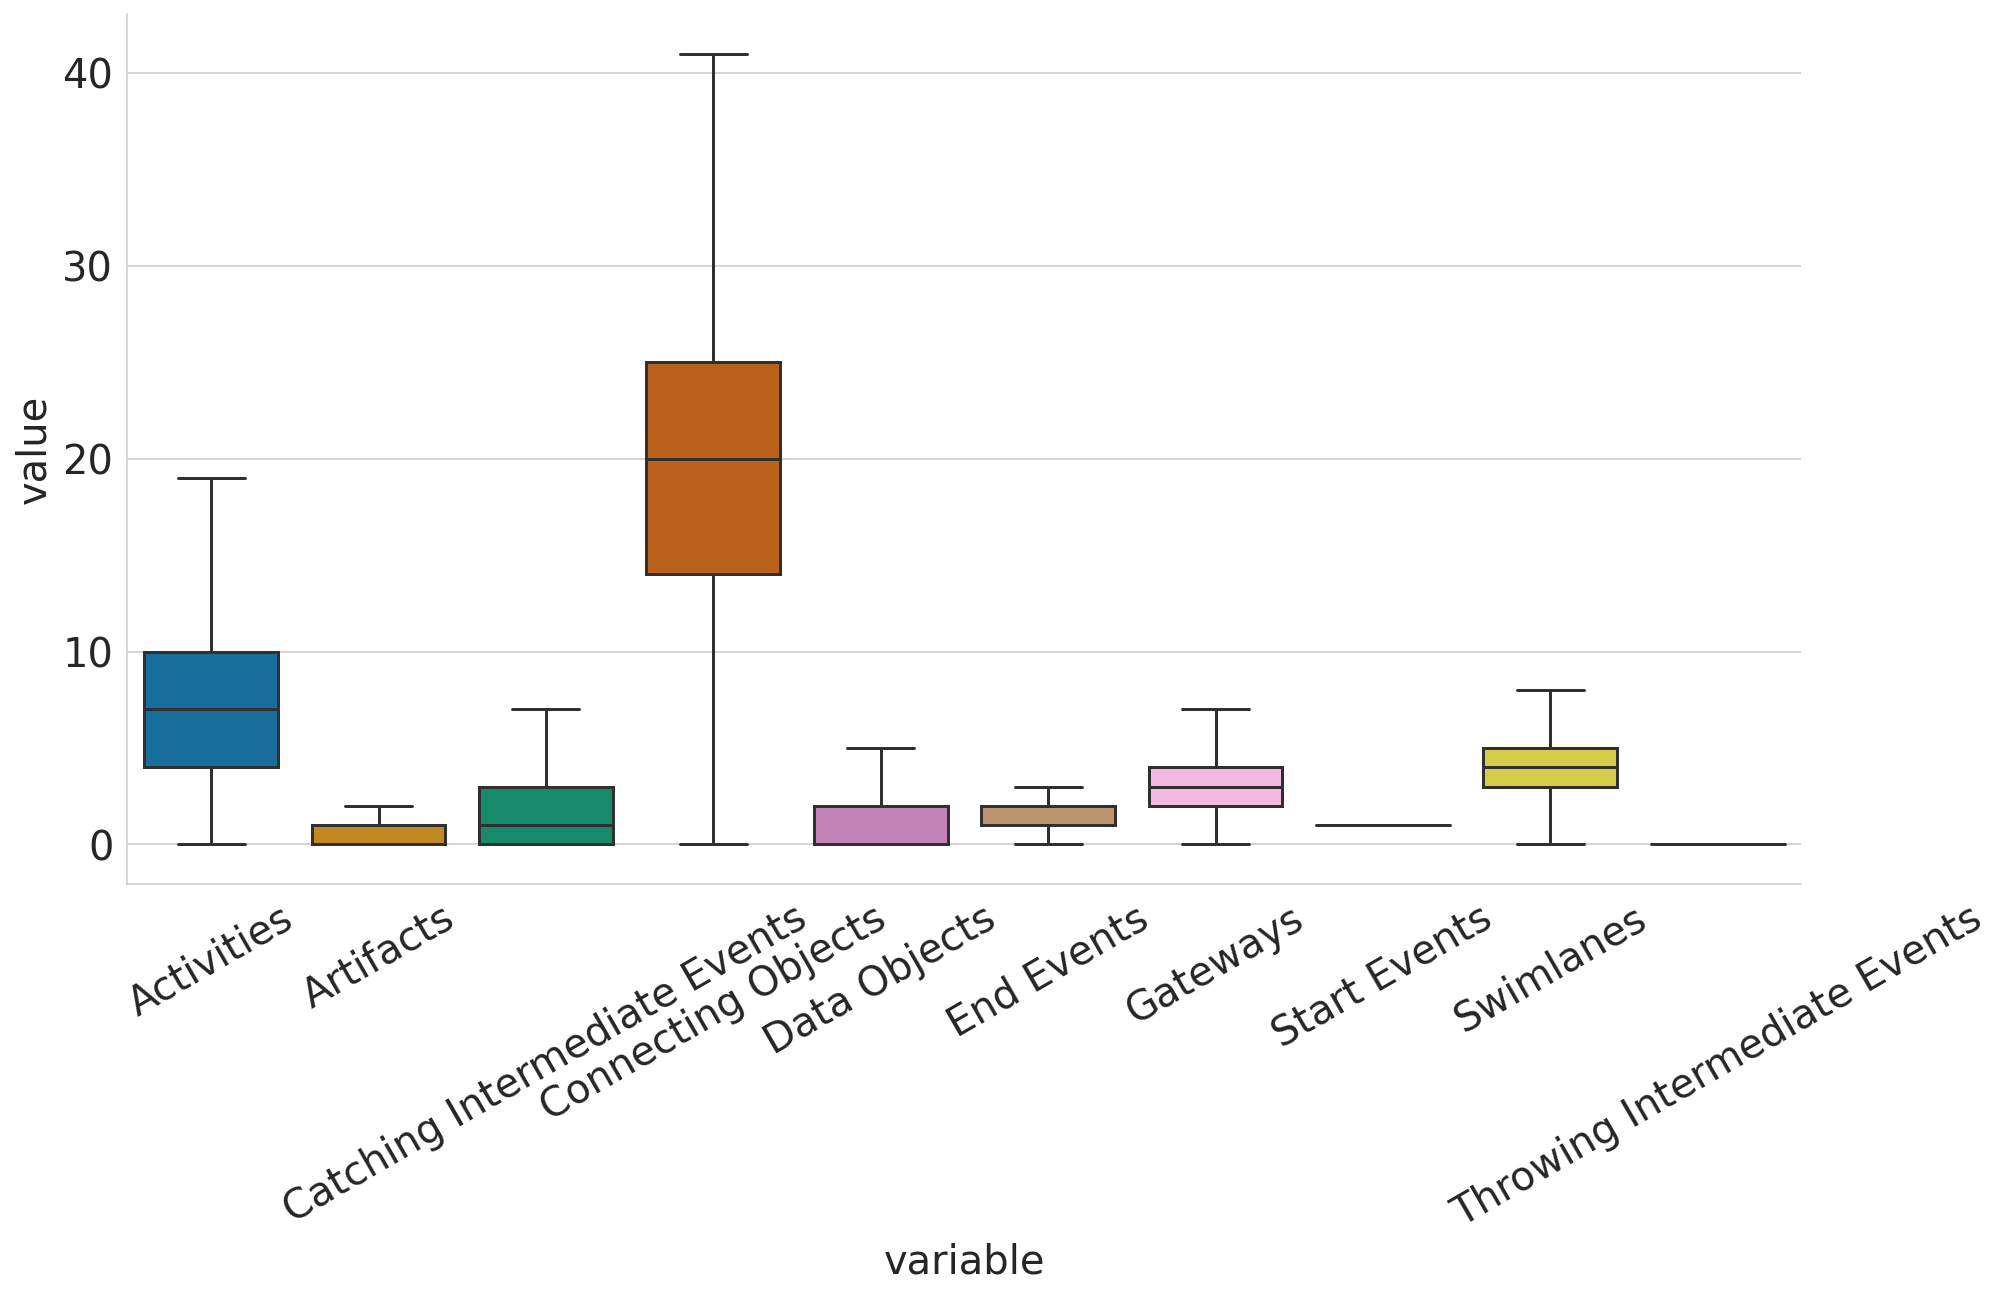

In [43]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Catching Intermediate Events', 'Connecting Objects', 'Data Objects', 'End Events', 'Gateways', 'Start Events', 'Swimlanes', 'Throwing Intermediate Events'])
ax=sns.boxplot(x="variable", y="value", data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind"))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [44]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
No. of Edges,605506.0,23.118230,21.829501,0.0,14.0,20.0,25.0,2066.0
No. of Nodes,605506.0,23.608565,19.973787,0.0,16.0,20.0,25.0,1873.0


In [45]:
df_high_level.head()

,No. of Edges,No. of Nodes
0,4,5
1,20,20
2,9,12
3,16,17
4,15,16


The number of nodes and edges is naturally highly correlated:

<Figure size 360x360 with 0 Axes>

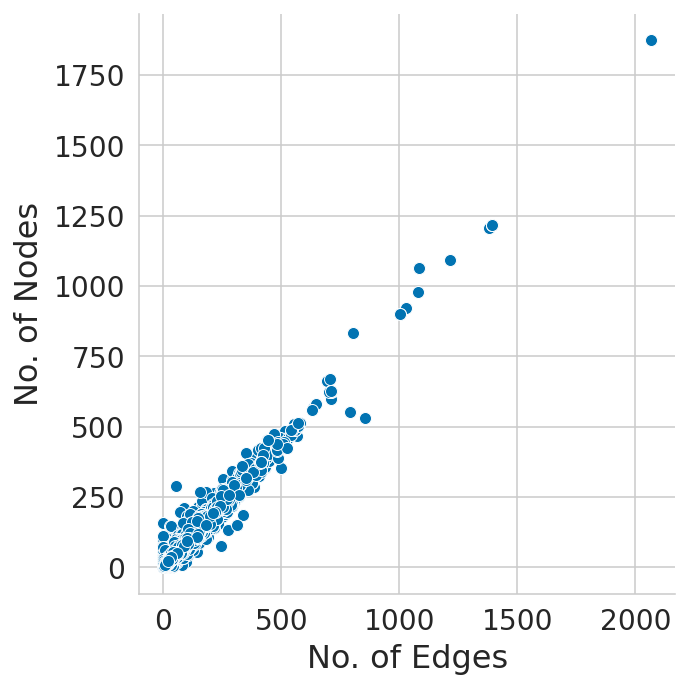

In [46]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'relplot.pdf',transparent=True,bbox_inches = 'tight')

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [47]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [48]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

,name,occurrences
0,Employee Onboarding,31822
1,Receipt of Goods,31820
2,Procure parts,31814
3,Verify applicant,31806
4,Level 2 - Process Area: Product Development,31805
5,Level 2 - Process Area: Human Resources,31805
6,Procurement of Work Equipment,31805
7,Check quantity and quality,31805
8,Receipt of Application,31803
9,Level 2 - Process Area: Order Processing,31798


The number of distinct process names:

In [49]:
len(cnts_names)

328321

We use Signavio's color palette for the word cloud.

In [50]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

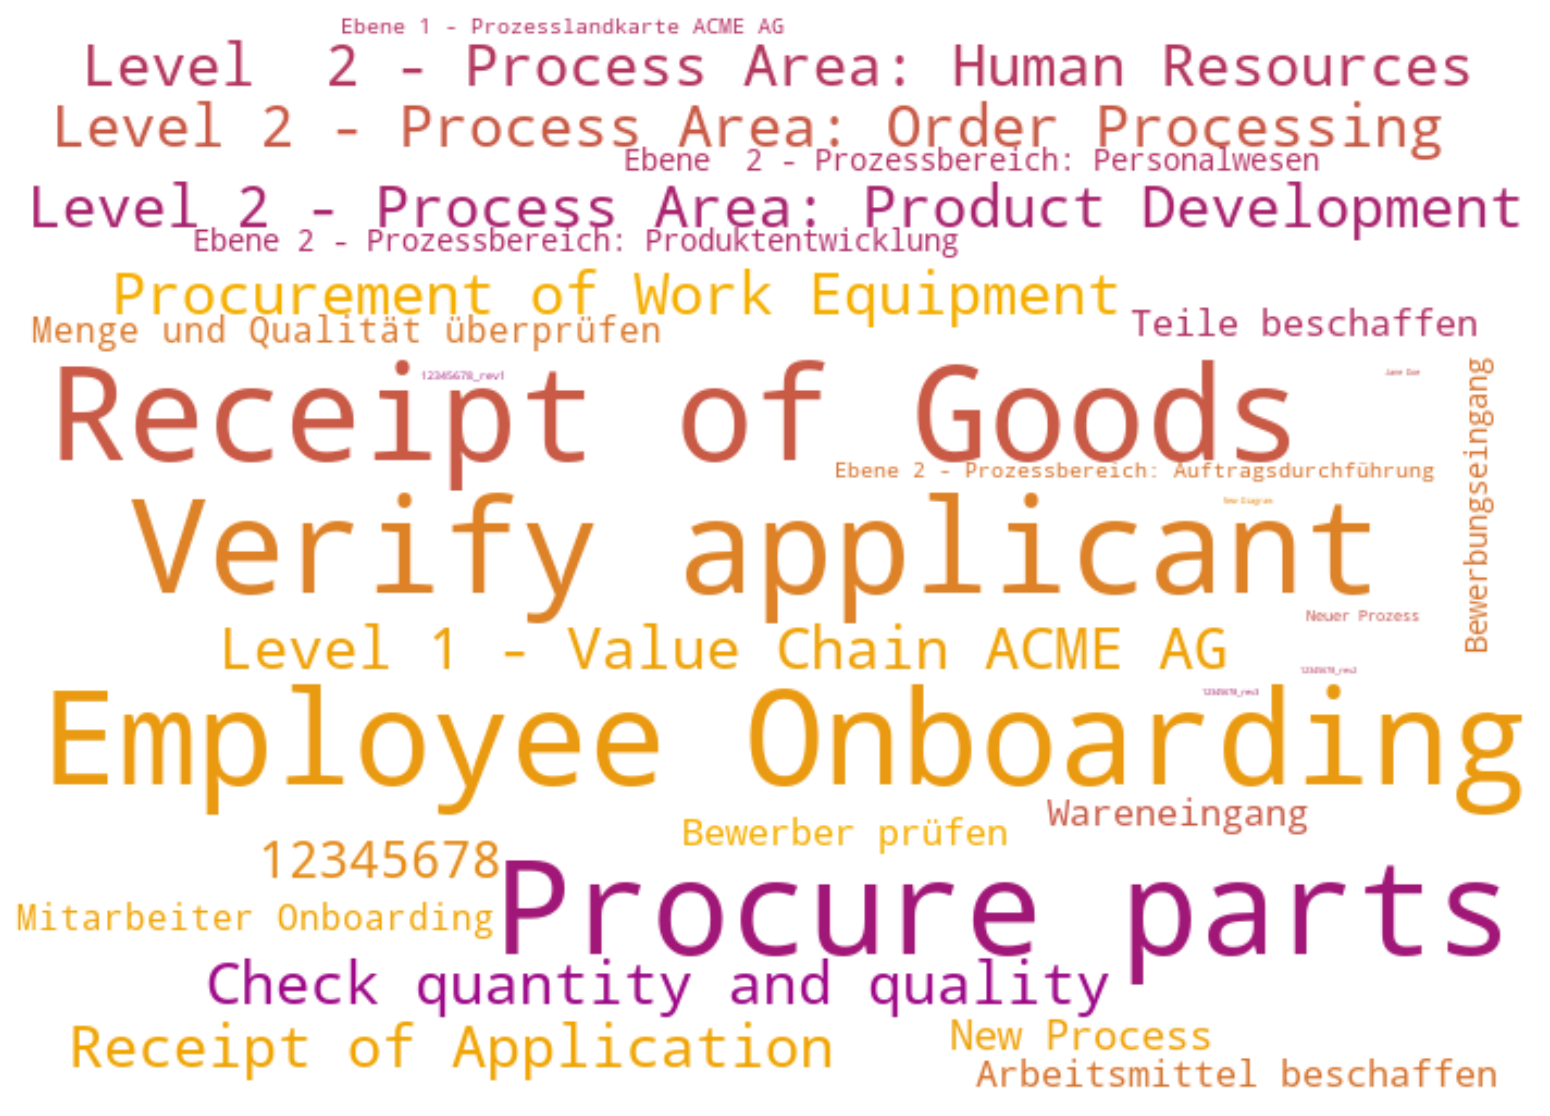

In [51]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [52]:
#cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.head(10)

,label,occurrences
2,ACME AG,215731
3,No,179073
4,Yes,158314
5,ERP-System,139391
6,Supplier,99560
7,no,79254
8,yes,70321
9,Procurement,64664
10,Human Resources Department,64008
11,Specify and quantify requirements,63714


The number of distinct element labels:

In [53]:
len(cnts_labels)

2820531

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [54]:
len(df_bpmn)

28293762

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [55]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.7405454866714983

... while 64.9 % of the labels are used for only one element.

In [56]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.6487753547115773

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [57]:
bins = cnts_labels.sort_values(by="occurrences",ascending=False)
bins.reset_index(inplace=True)
bins.head()

,index,label,occurrences
0,2,ACME AG,215731
1,3,No,179073
2,4,Yes,158314
3,5,ERP-System,139391
4,6,Supplier,99560


We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [58]:
N = 10000
bins = bins.groupby(bins.index // N).sum()

In [59]:
import math
bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

,index,occurrences,bins of labels
0,50019977,7375127,10000
1,150050026,461098,20000
2,250381224,287191,30000
3,350356209,212010,40000
4,450291699,170849,50000


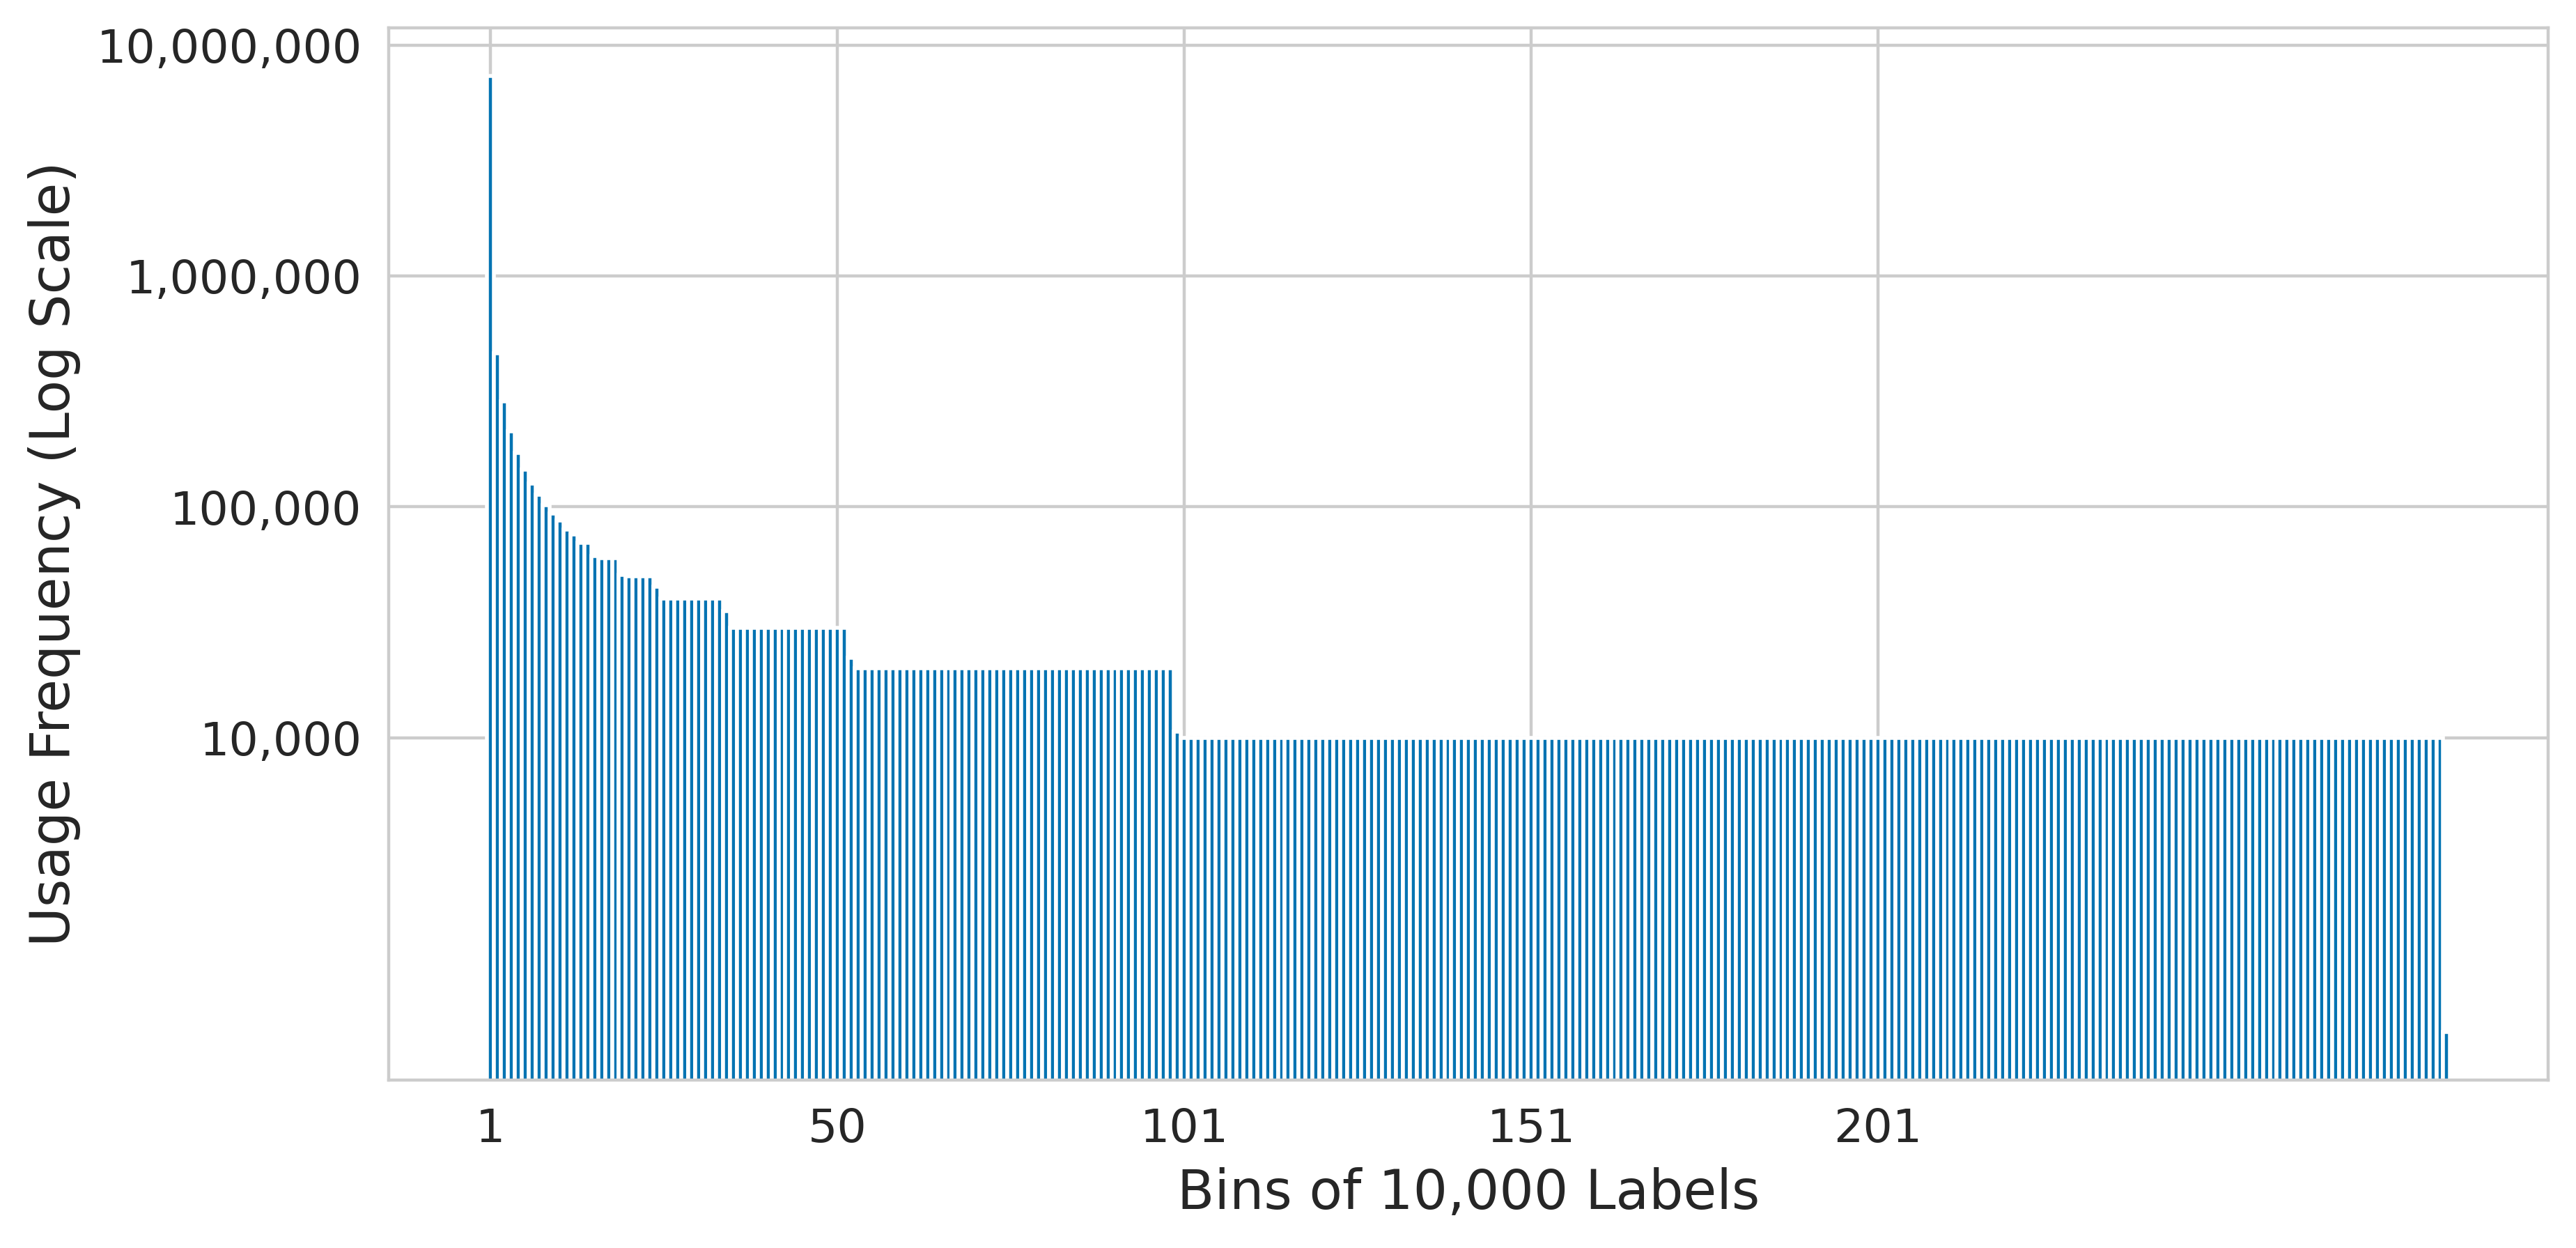

In [60]:
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,283)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

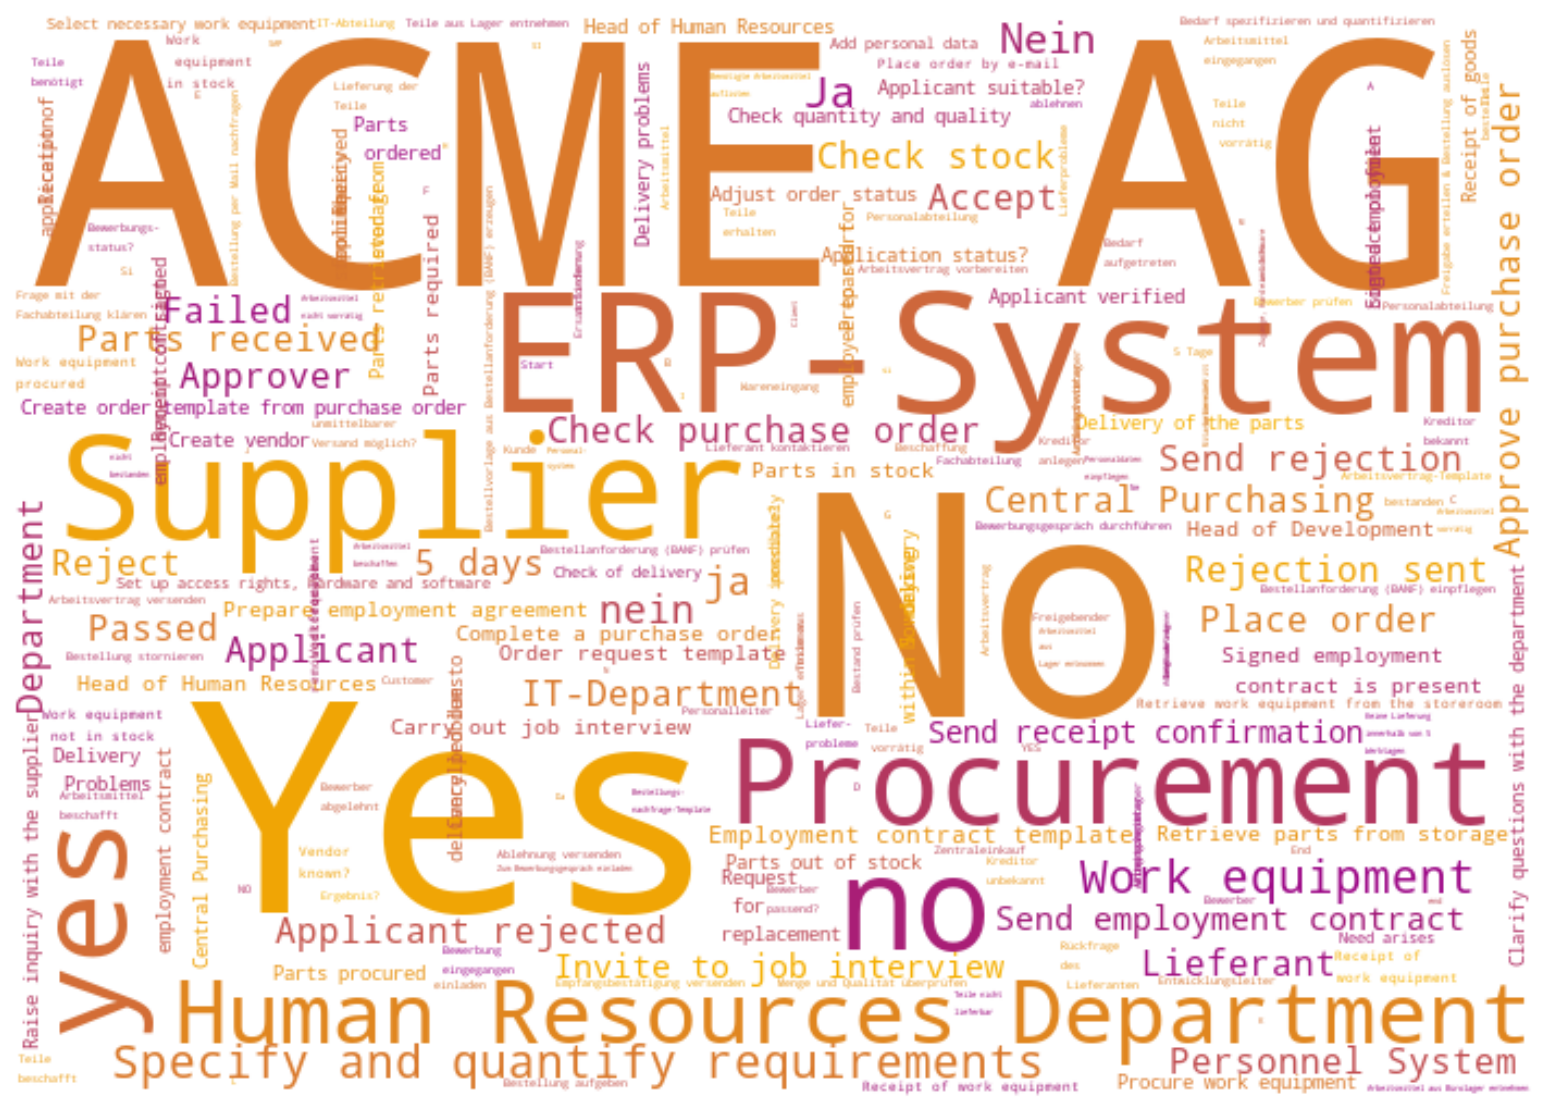

In [61]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Example Processes

The dataset includes the following vendor provided example processes.

In [62]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

In [63]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

This is the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [64]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

471496

In [65]:
len(df_meta_examples)/len(df_meta)

0.4615853019811625

This is the number of models in the dataset without example processes (again, based on process names):

In [66]:
len(df_meta)-len(df_meta_examples)

549975

In [67]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.5384146980188376